In [1]:
import pymc as pm


parameter = pm.Exponential("poisson_param", 1)
data_generator = pm.Poisson("data_generator", parameter)
data_plus_one = data_generator + 1

In [2]:
print "Children of `parameter`: "
print parameter.children
print "\nParents of `data_generator`: "
print data_generator.parents
print "\nChildren of `data_generator`: "
print data_generator.children

Children of `parameter`: 
set([<pymc.distributions.Poisson 'data_generator' at 0x000000002116E390>])

Parents of `data_generator`: 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x0000000004161160>}

Children of `data_generator`: 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x00000000041610F0>])


In [3]:
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)

In [4]:
lambda_1 = pm.Exponential("lambda_1", 1)  # prior on first behaviour
lambda_2 = pm.Exponential("lambda_2", 1)  # prior on second behaviour
tau = pm.DiscreteUniform("tau", lower=0, upper=10)  # prior on behaviour change

print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value
print

lambda_1.random(), lambda_2.random(), tau.random()

print "After calling random() on the variables..."
print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value

lambda_1.value = 0.785
lambda_2.value = 2.307
tau.value = 9.000

After calling random() on the variables...
lambda_1.value = 0.054
lambda_2.value = 0.033
tau.value = 2.000


In [5]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [6]:
import numpy as np
n_data_points = 5  # in CH1 we had ~70 data points


@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after tau is lambda2
    return out

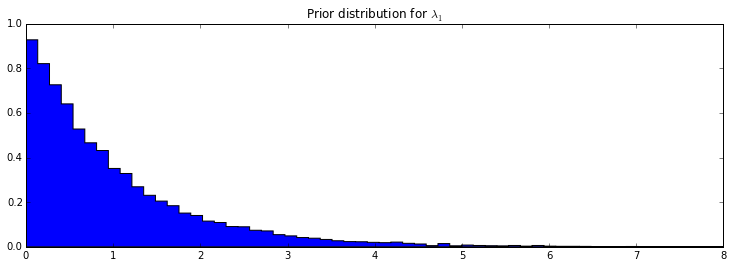

In [7]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)


samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

In [8]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print "value: ", fixed_variable.value
print "calling .random()"
fixed_variable.random()
print "value: ", fixed_variable.value

value:  [10  5]
calling .random()
value:  [10  5]


In [9]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print obs.value

[10 25 15 20 35]


In [10]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

In [11]:
tau = pm.rdiscrete_uniform(0, 80)
print tau

14


In [12]:
alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2

15.0153485031 8.37344867112


In [13]:
data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]

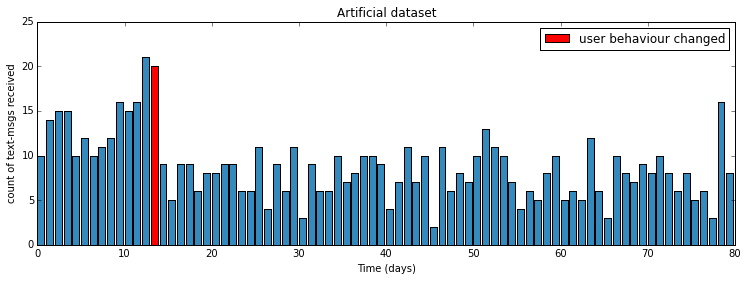

In [14]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

In [15]:
import pymc as pm

# The parameters are the bounds of the Uniform.
p = pm.Uniform('p', lower=0, upper=1)

In [20]:
# set constants
p_true = 0.05  # remember, this is unknown.
N = 3000

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = pm.rbernoulli(p_true, N)

print occurrences  # Remember: Python treats True == 1, and False == 0
print occurrences.sum()

[False False False ..., False False False]
150


In [21]:
# Occurrences.mean is equal to n/N.
print "What is the observed frequency in Group A? %.4f" % occurrences.mean()
print "Does this equal the true frequency? %s" % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0500
Does this equal the true frequency? True


In [22]:
# include the observations, which are Bernoulli
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# To be explained in chapter 3
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 1.5 sec

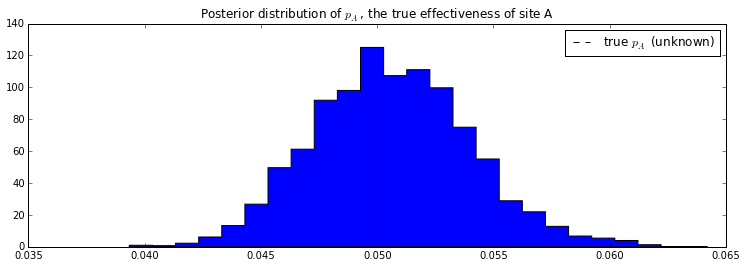

In [23]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend()

In [24]:
import pymc as pm
figsize(12, 4)

# these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

# generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Obs from Site A: ", observations_A[:30].astype(int), "..."
print "Obs from Site B: ", observations_B[:30].astype(int), "..."

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [25]:
print observations_A.mean()
print observations_B.mean()

0.0513333333333
0.0373333333333


In [26]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# To be explained in chapter 3.
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.7 sec

In [27]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

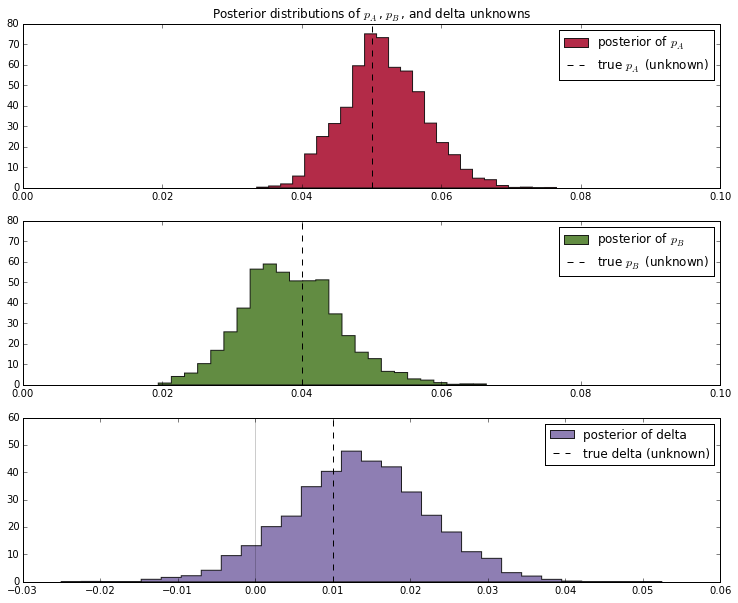

In [28]:
figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [29]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print "Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.071
Probability site A is BETTER than site B: 0.929


In [30]:
import pymc as pm

N = 100
p = pm.Uniform("freq_cheating", 0, 1)

In [31]:
true_answers = pm.Bernoulli("truths", p, size=N)

In [32]:
first_coin_flips = pm.Bernoulli("first_flips", 0.5, size=N)
print first_coin_flips.value

[ True  True False  True False  True False  True False  True  True False
  True  True False False False  True False False  True False  True False
 False False False  True False False  True False  True False False False
  True  True  True  True False  True False False False  True  True  True
 False  True  True  True False False False False False False  True  True
  True False  True  True  True False False  True False  True  True False
  True False  True  True  True False  True False False  True  True  True
 False False  True False False False  True False  True False  True  True
  True False False  True]


In [33]:
second_coin_flips = pm.Bernoulli("second_flips", 0.5, size=N)

In [34]:
@pm.deterministic
def observed_proportion(t_a=true_answers,
                        fc=first_coin_flips,
                        sc=second_coin_flips):

    observed = fc * t_a + (1 - fc) * sc
    return observed.sum() / float(N)

In [35]:
observed_proportion.value

0.33000000000000002

In [36]:
X = 35

observations = pm.Binomial("obs", N, observed_proportion, observed=True,
                           value=X)

In [37]:
model = pm.Model([p, true_answers, first_coin_flips,
                  second_coin_flips, observed_proportion, observations])

# To be explained in Chapter 3!
mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 8.4 sec

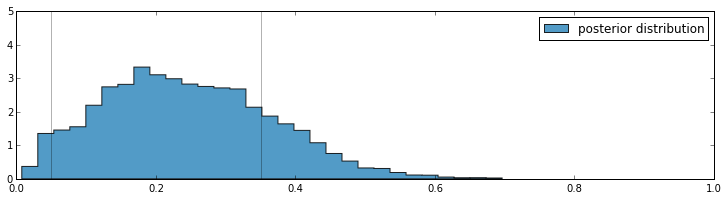

In [38]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

In [39]:
p = pm.Uniform("freq_cheating", 0, 1)


@pm.deterministic
def p_skewed(p=p):
    return 0.5 * p + 0.25

In [40]:
yes_responses = pm.Binomial("number_cheaters", 100, p_skewed,
                            value=35, observed=True)
print yes_responses

number_cheaters


In [41]:
print yes_responses.value

35


In [42]:
model = pm.Model([yes_responses, p_skewed, p])

# To Be Explained in Chapter 3!
mcmc = pm.MCMC(model)
mcmc.sample(25000, 2500)

 [-----------------100%-----------------] 25000 of 25000 complete in 0.9 sec

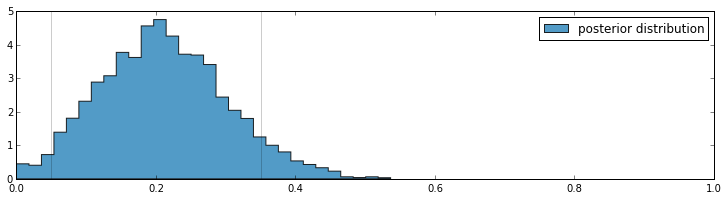

In [43]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

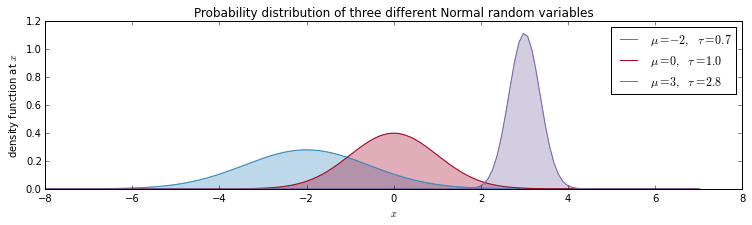

In [44]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1. / _tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1. / _tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");